# 5. Análisis predictivo con KNN

#### 2.1 Dependencias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.svm import SVC

#### 2.2 Cargar fichero

In [2]:
ruta_fichero = '../data_generated/datos_meteorologicos_modificados_sin_prec.csv'
fichero = pd.read_csv(ruta_fichero)
fichero

,altitud,tmed,tmin,tmax,dir,velmedia,racha,presMax,presMin,lluvia
0,115,23.5,19.7,27.3,7.0,3.1,8.1,1005.4,1003.1,False
1,410,26.2,17.4,35.1,19.0,4.2,11.4,975.0,971.6,False
2,808,27.0,19.0,35.0,12.0,2.2,8.3,931.8,928.9,False
3,582,23.8,13.0,34.5,99.0,1.4,4.2,957.9,953.3,False
4,17,23.3,18.6,28.0,20.0,2.2,6.1,1021.5,1019.5,False
...,...,...,...,...,...,...,...,...,...,...
7591,23,19.2,13.5,24.3,22.0,2.5,8.9,974.0,969.3,False
7592,8,18.6,14.3,23.0,26.0,5.8,16.9,1014.9,1010.3,False
7593,4,17.8,11.0,24.5,22.0,2.5,8.9,974.0,969.3,False
7594,769,12.6,10.2,15.1,23.0,7.2,19.7,926.7,919.2,True


In [3]:
X = fichero.drop('lluvia', axis=1)  # Features
y = fichero['lluvia']  # Variable de salida

# División en 80/20 para entrenamiento y val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear conjuntos de entrenamiento y prueba
conjunto_train = pd.concat([X_train, y_train], axis=1)
conjunto_val = pd.concat([X_val, y_val], axis=1)


# Creamos dos conjuntos para poner las predicciones del train y test
conjunto_train_eval = conjunto_train.copy()
conjunto_validation_eval = conjunto_val.copy()

In [4]:
precision_train = {}
precision_val = {}

## TRAIN CON SVM LINEAR

In [5]:
# Método de control (k-fold cross-validation)
metodo_control_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [6]:
# Establecer la semilla para reproducibilidad
np.random.seed(150)

linear_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])

linear_svm_params = {'svm__C': np.arange(0.1, 11, 1)}

In [7]:
# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
linear_svm_grid = GridSearchCV(linear_svm_pipeline, linear_svm_params, scoring='accuracy', cv=metodo_control_cv)
linear_svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(kernel='linear'))]),
             param_grid={'svm__C': array([ 0.1,  1.1,  2.1,  3.1,  4.1,  5.1,  6.1,  7.1,  8.1,  9.1, 10.1])},
             scoring='accuracy')

In [8]:
# Obtener el mejor modelo
best_linear_svm_model = linear_svm_grid.best_estimator_
print(best_linear_svm_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=2.1, kernel='linear'))])


In [9]:
# Evaluación del modelo SVM lineal
linear_svm_train_predictions = cross_val_predict(linear_svm_grid.best_estimator_, X_train, y_train, cv=10)
linear_svm_test_predictions = linear_svm_grid.predict(X_val)


# Matrices de confusión
linear_svm_train_conf_matrix = confusion_matrix(y_train, linear_svm_train_predictions)
linear_svm_test_conf_matrix = confusion_matrix(y_val, linear_svm_test_predictions)

In [10]:
linear_svm_train_conf_matrix

array([[2979,  627],
       [ 752, 1718]], dtype=int64)

In [11]:
linear_svm_test_conf_matrix

array([[772, 134],
       [183, 431]], dtype=int64)

In [12]:
# Predecir las etiquetas para el conjunto de entrenamiento
y_pred_train = best_linear_svm_model.predict(X_train)

# Calcular y mostrar la precisión del modelo en el conjunto de entrenamiento
precision_entrenamiento = accuracy_score(y_train, y_pred_train)
print(f"Precisión en el conjunto de entrenamiento: {precision_entrenamiento:.2%}")


Precisión en el conjunto de entrenamiento: 77.40%


C:\Users\34673\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but StandardScaler is expecting 9 features as input.

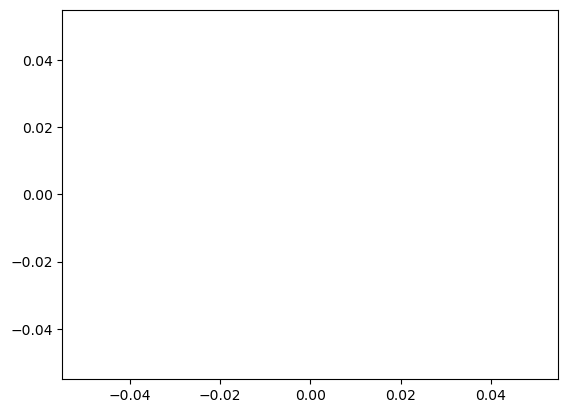

In [20]:
# Obtener los vectores de soporte
support_vectors = best_linear_svm_model.named_steps['svm'].support_vectors_

# Graficar el conjunto de entrenamiento con la línea de separación y los márgenes
plt.scatter(X_train['racha'], X_train['tmed'], c=y_train.map({'NO': 'red', 'YES': 'blue'}))

# Crear un meshgrid para visualizar la línea de separación
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = best_linear_svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Graficar las líneas de separación y los márgenes
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Etiquetas y título
plt.title("SVM Lineal - Training Set con Línea de Separación y Márgenes")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

## CONCLUSION

Hasta el momento, has implementado un modelo SVM, pero te has encontrado con problemas técnicos específicos al intentar visualizar los resultados. Esto sugiere que el modelo en sí podría estar implementado correctamente, pero los problemas surgen en la etapa de visualización y análisis de los resultados.

 Aunque es frustrante enfrentarse a errores técnicos, son una parte normal del proceso de desarrollo de modelos de machine learning. Solucionar estos problemas no solo te ayudará a completar tu modelo SVM actual, sino que también te brindará habilidades valiosas para la resolución de problemas en proyectos futuros.